# Coarse Graining with HOOMD-Organics

## Overview:

Coarse graining in molecular dynamics (MD) simplifies complex systems by grouping atoms or molecules into beads, enhancing computational efficiency and enabling simulations on extended time scales.

The `HOOMD-Organics` package is designed in a way that simplifies the execution of MD simulations for coarse-grained systems. This is achieved by incorporating built-in functionalities that can transform an all-atom system into coarse-grained beads and define the force interactions between these beads, all with minimal user-side coding effort.

In this tutorial, we will go through the steps required to convert an all-atom strucutre to a coarse grained one and initialize a simulation for the modified system.

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from hoomd_organics.base import Pack, Simulation
from hoomd_organics.library import PPS, BeadSpring

### Step 1: Coarse graining an all-atom molecule

First, we initialize 300 atomistic PPS polymers and use the coarse graining method in `Molecule` to group atoms in one PPS molecule into a single bead.

In [5]:
pps_mol = PPS(num_mols=300, lengths=6)

First, let's examine the atomistic visualization of one of the PPS chains.

In [ ]:
pps_mol.molecules[0].visualize()

The `coarse_grain` method invokes the `GRiTS` coarse graining toolkit in the background. The `GRiTS` package, when provided with the SMILES notations of the beads, scans the atomic structure and automatically substitutes groups of atoms that match the SMILES pattern with a respective beads. 

In our PPS example, the `beads` parameter consists of a dictionary mapping arbitrary bead names (for example, here we named the bead "A") to their corresponding SMILES strings. Note that a strucuture can be coarse grained into multiple types of beads. Please see the example at the end of this tutorial for clarrification. 

In [6]:
pps_mol.coarse_grain(beads={"A": "c1ccc(S)cc1"})

**Important note regarding `coarse_grain`**: The coarse-grain method performs in-place alterations, resulting in the transformation of `pps_mol` from an all-atom structure to one where all particles are substituted with corresponding coarse-grained beads

As you can see in the visualization below, all the individual monomers have been substituted with "A" beads.

In [ ]:
pps_mol.molecules[0].visualize()

### Step 2: Define forces

To define the bonded and non-bonded interactions among the coarse beads, we utiize the `BeadSpring` class from the `HOOMD-Organics` libraray. This class generates a list of HOOMD force objects representing the Lennard-Jones (LJ) forces for the non-bonded interactions and harmonic bond forces, harmonic angle forces and periodic dihedral forces for the bonded interactions.

For each of these forces, specific parameters must be provided. Fpr instance, the LJ force requires `epsilon` and `sigma` parameters.
Please check [`HOOMD-Blue` documentation](https://hoomd-blue.readthedocs.io/en/stable/module-md-bond.html) for detailed information about the parameters required for [harmonic bonds](https://hoomd-blue.readthedocs.io/en/v4.1.0/module-md-bond.html), [harmonic angles](https://hoomd-blue.readthedocs.io/en/stable/module-md-angle.html) and [periodic rdihedrals](https://hoomd-blue.readthedocs.io/en/stable/module-md-dihedral.html).  

It's worth noting that the `BeadSpring` class serves as an illustrative example, generating forces based on commonly used force types. However, users have the flexibility to implement their own methods or classes to generate HOOMD force objects tailored to their specific requirements.

In [45]:
ff = BeadSpring(
    r_cut=2.5,
    beads={
        "A": dict(epsilon=1.0, sigma=1.0),
    },
    bonds={
        "A-A": dict(r0=1.1, k=300),
    },
    angles={"A-A-A": dict(t0=2.0, k=200)},
    dihedrals={"A-A-A-A": dict(phi0=0.0, k=100, d=-1, n=1)},
)

### Step 3: Create the system

Using the `Pack` class, we pack a box of coarse grained chains. Note that, since the list of HOOMD force objects for the system has already been defined, there is no requirement to pass the `forcefield` parameter when configuring the system.

In [34]:
cg_system = Pack(molecules=pps_mol, density=0.1, r_cut=2.5, auto_scale=False)

In [ ]:
cg_system.system.visualize()

### Step 4: Start the simulation

similar to initializing an atomisitc simulation, we pass in the `hoomd_snapshot` generated by the system along with the force objects generated by the `BeadSpring` class to start a simulation.

In [46]:
cg_sim = Simulation.from_system(system=cg_system, forcefield=ff.hoomd_forcefield)

Initializing simulation state from a gsd.hoomd.Frame.


In [31]:
cg_system.hoomd_snapshot.particles.types

['A']

In [50]:
cg_sim.run_NVT(n_steps=1e3, kT=1.0, tau_kt=1.0)

In [51]:
import hoomd
for writer in cg_sim.operations.writers:
    if isinstance(writer, hoomd.write.GSD):
        writer.flush()

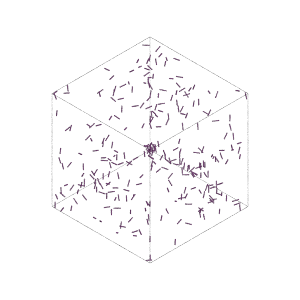

In [52]:
from cmeutils.visualize import FresnelGSD

sim_visualizer = FresnelGSD(gsd_file="trajectory.gsd", frame=-1, view_axis=(1, 1, 1))
sim_visualizer.view()